## Import Necessary Libraries

In [48]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import zipfile
import random
import shutil
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping

print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.12.0
Using backend: tensorflow


### Check Device Availability

Let's verify whether GPU acceleration is available for faster training:

In [49]:
# Check for GPU availability
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("  Training will be significantly faster on GPU!")
else:
    device = torch.device("cpu")
    print("⚠ No GPU detected - using CPU")
    print("  Training will be slower. Consider using Google Colab or Kaggle Kernel for free GPU access.")

⚠ No GPU detected - using CPU
  Training will be slower. Consider using Google Colab or Kaggle Kernel for free GPU access.


## Import Data

In [50]:
source_path = 'breast_cancer_data'

for label in ['benign', 'malignant', 'normal']:
    print(f"There are {len(os.listdir(os.path.join(source_path, str(label))))} images of {label} tumor status.")

There are 438 images of benign tumor status.
There are 211 images of malignant tumor status.
There are 134 images of normal tumor status.


## Visual Exploration

Display random sample images from each of the three diagnosis classes to understand data better:

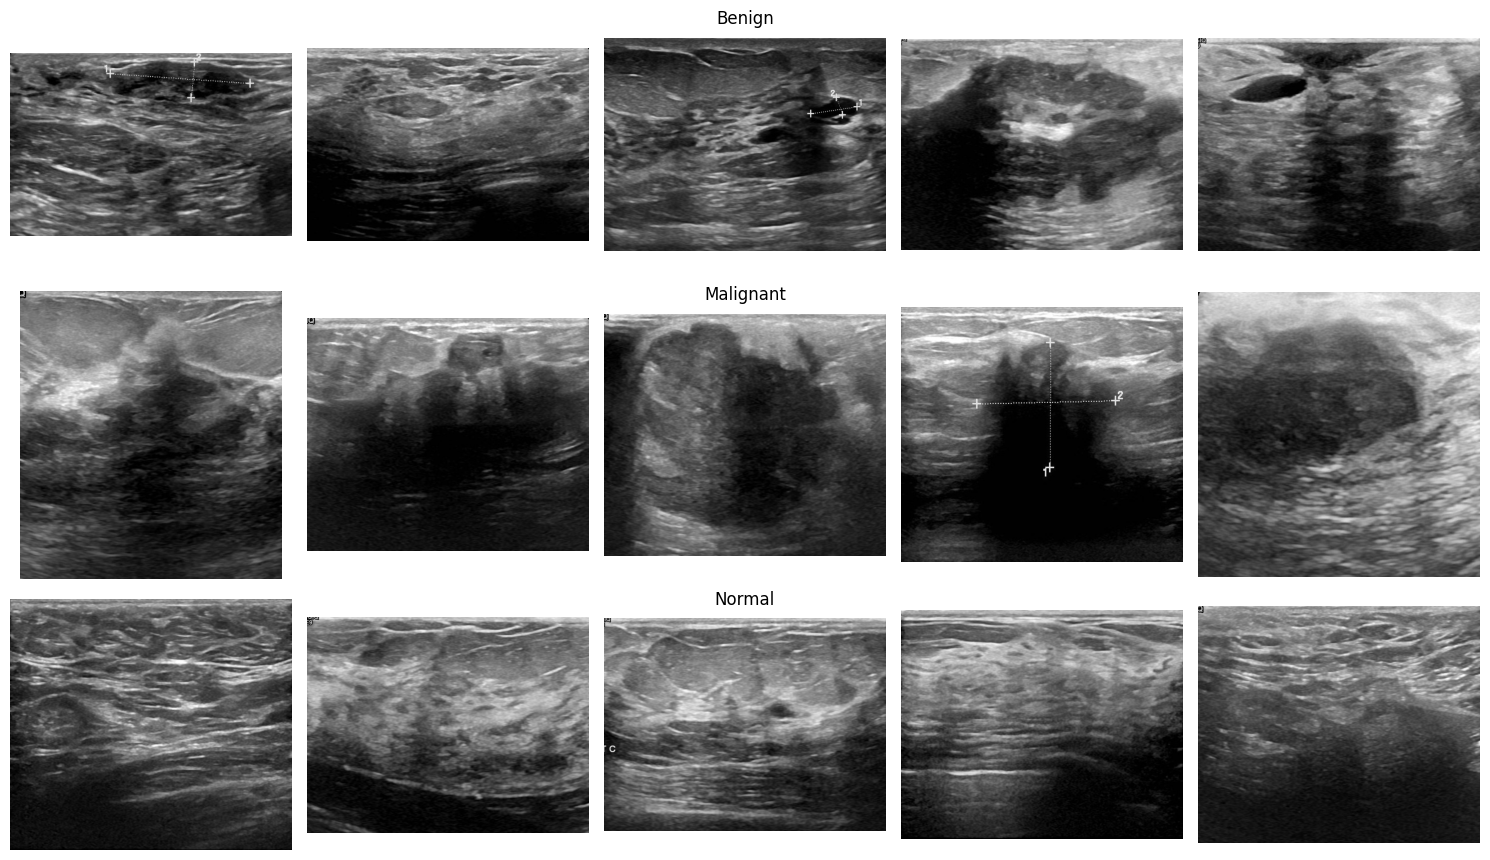

In [51]:
fig = plt.figure(figsize=(15, 9))
for i, class_name in enumerate(['benign', 'malignant', 'normal']):
    class_path = f'breast_cancer_data/{class_name}'
    images = os.listdir(class_path)
    
    for j in range(5):
        img = plt.imread(f'{class_path}/{random.choice(images)}')
        fig.add_subplot(3, 5, i*5+j+1)
        plt.axis('off')
        plt.imshow(img, cmap='gray')
        if j == 2:
            plt.title(class_name.capitalize(), fontsize=12, pad=10)

plt.tight_layout()
plt.show()

In [52]:
# print out the size of each image
img = plt.imread(f'breast_cancer_data/benign/{random.choice(os.listdir("breast_cancer_data/benign"))}')
print(f"Image size: {img.shape}")

Image size: (696, 841, 3)


## Create New File Storage Directories

In [53]:
#new root directory
root_dir = 'split_data'

#empty directory to prevent future issues
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
  for name in ['benign', 'malignant', 'normal']:
    for name2 in ['training','validation','test']:
      os.makedirs(os.path.join(root_path,name2,str(name)))

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("Error: File already exists.")

In [54]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

split_data/test
split_data/training
split_data/validation
split_data/test/malignant
split_data/test/benign
split_data/test/normal
split_data/training/malignant
split_data/training/benign
split_data/training/normal
split_data/validation/malignant
split_data/validation/benign
split_data/validation/normal


## Split Data into Train, Test, Val datasets

In [55]:
#create directories for split data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, TRAIN_SPLIT, VAL_SPLIT):
    np.random.seed(42)
    files = []
    for name in os.listdir(SOURCE_DIR):
        if os.path.getsize(os.path.join(SOURCE_DIR, name)) > 0:
            files.append(name)
    random.shuffle(files)

    train_size = int(len(files) * TRAIN_SPLIT)
    val_size = int(len(files) * VAL_SPLIT)

    for name in files[:train_size]:
        shutil.copy(os.path.join(SOURCE_DIR, name), os.path.join(TRAINING_DIR, name))
    for name in files[train_size:train_size + val_size]:
        shutil.copy(os.path.join(SOURCE_DIR, name), os.path.join(VALIDATION_DIR, name))
    for name in files[train_size + val_size:]:
        shutil.copy(os.path.join(SOURCE_DIR, name), os.path.join(TEST_DIR, name))

In [56]:
TRAINING_DIR = "split_data/training/"
VALIDATION_DIR = "split_data/validation/"
TEST_DIR = "split_data/test/"

#empty directories to prevent future errors from multiple runs
for i in ['benign', 'malignant', 'normal']:
  label_train_dir = os.path.join(TRAINING_DIR, str(i))
  label_val_dir = os.path.join(VALIDATION_DIR, str(i))
  label_test_dir = os.path.join(TEST_DIR, str(i))
  if len(os.listdir(label_train_dir)) > 0:
    for file in os.scandir(label_train_dir):
      os.remove(file.path)
  if len(os.listdir(label_val_dir)) > 0:
    for file in os.scandir(label_val_dir):
      os.remove(file.path)
  if len(os.listdir(label_test_dir)) > 0:
    for file in os.scandir(label_test_dir):
      os.remove(file.path)

#split proportions
train_split = 0.7
val_split = 0.2
test_split = 0.1

#execute split
for i in ['benign', 'malignant', 'normal']:
  label_train_dir = os.path.join(TRAINING_DIR, str(i))
  label_val_dir = os.path.join(VALIDATION_DIR, str(i))
  label_test_dir = os.path.join(TEST_DIR, str(i))
  split_data(SOURCE_DIR=os.path.join(source_path, str(i)),
             TRAINING_DIR=label_train_dir,
             VALIDATION_DIR=label_val_dir,
             TEST_DIR=label_test_dir,
             TRAIN_SPLIT=train_split,
             VAL_SPLIT=val_split)

#print number of files in each group
for i in ['benign', 'malignant', 'normal']:
  print(f"There are {len(os.listdir(os.path.join(TRAINING_DIR, str(i))))} images of a {i} tumor diagnosis in the training set")
  print(f"There are {len(os.listdir(os.path.join(VALIDATION_DIR, str(i))))} images of a {i} tumor diagnosis in the validation set")
  print(f"There are {len(os.listdir(os.path.join(TEST_DIR, str(i))))} images of a {i} tumor diagnosis in the test set")


There are 306 images of a benign tumor diagnosis in the training set
There are 87 images of a benign tumor diagnosis in the validation set
There are 45 images of a benign tumor diagnosis in the test set
There are 147 images of a malignant tumor diagnosis in the training set
There are 42 images of a malignant tumor diagnosis in the validation set
There are 22 images of a malignant tumor diagnosis in the test set
There are 93 images of a normal tumor diagnosis in the training set
There are 26 images of a normal tumor diagnosis in the validation set
There are 15 images of a normal tumor diagnosis in the test set


## Create Data Generators with Augmentation

In [57]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  #create the ImageDataGenerator class for the training set
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
  
  #only apply the rescale transformation to the validation and test sets
  val_test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='sparse',
                                                      target_size=(224, 224))
  validation_generator = val_test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='sparse',
                                                              target_size=(224, 224))
  test_generator = val_test_datagen.flow_from_directory(directory=TEST_DIR,
                                                        batch_size=32,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  return train_generator, validation_generator, test_generator


In [58]:
# Test your generators
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

Found 543 images belonging to 3 classes.
Found 155 images belonging to 3 classes.
Found 82 images belonging to 3 classes.


## CNN model

In [59]:
# GRADED FUNCTION: create_model
def create_model():

  model = keras.models.Sequential([

    keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")

  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [60]:
#create untrained model
cnn_model = create_model()

/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
#model summary
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,091,530 (49.94 MB)

 Trainable params: 13,091,530 (49.94 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
#set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)
]

In [64]:
# Train the model
history = cnn_model.fit(train_generator, validation_data=validation_generator, epochs=30, callbacks = callbacks)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 568ms/step - accuracy: 0.4586 - loss: 1.2649 - val_accuracy: 0.5613 - val_loss: 0.9896
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 534ms/step - accuracy: 0.5341 - loss: 1.0430 - val_accuracy: 0.6323 - val_loss: 0.9990
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 538ms/step - accuracy: 0.5488 - loss: 1.0158 - val_accuracy: 0.5613 - val_loss: 0.9297
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 531ms/step - accuracy: 0.5525 - loss: 0.9965 - val_accuracy: 0.5613 - val_loss: 0.9238
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 537ms/step - accuracy: 0.5525 - loss: 0.9679 - val_accuracy: 0.5677 - val_loss: 0.8711
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 536ms/step - accuracy: 0.5783 - loss: 0.9829 - val_accuracy: 0.6710 - val_loss: 0.9495
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 530ms/step - accuracy: 0.5691 - loss: 0.9874 - val_accuracy: 0.6323 - val_loss: 0.8528
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 542ms/step - accuracy: 0.5635 - loss: 0.9720 - val_accuracy: 0

## Display Training Progress

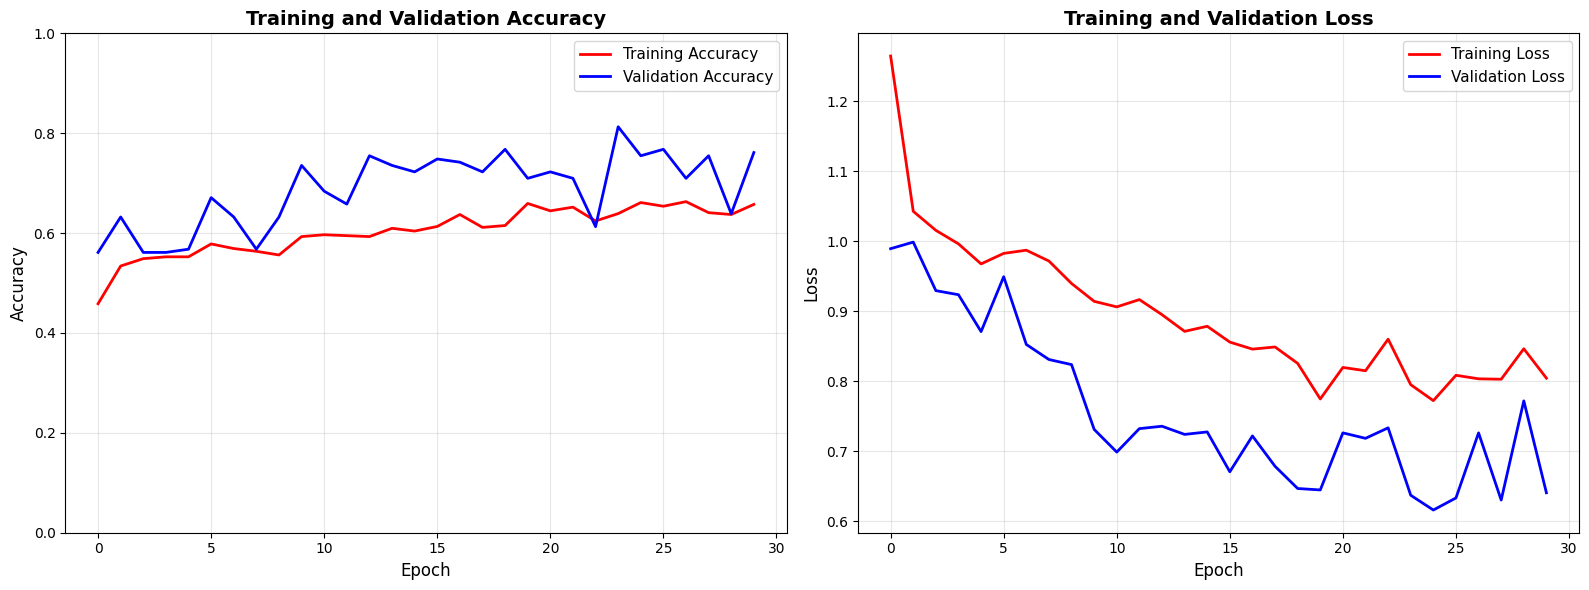


  Training Summary
  Best Training Accuracy:   0.6630 (epoch 27)
  Best Validation Accuracy: 0.8129 (epoch 24)
  Final Training Accuracy:  0.6575
  Final Validation Accuracy:0.7613
  Accuracy Gap (final):     0.1038


In [65]:
# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy
ax1.plot(epochs_range, acc, 'r-', linewidth=2, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, 'b-', linewidth=2, label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Loss
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"  Training Summary")
print(f"{'='*60}")
print(f"  Best Training Accuracy:   {max(acc):.4f} (epoch {acc.index(max(acc))+1})")
print(f"  Best Validation Accuracy: {max(val_acc):.4f} (epoch {val_acc.index(max(val_acc))+1})")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")
print(f"{'='*60}")

In addition to reporting your training and validation accuracy above, please also include your test accuracy below. Finally, comment on whether your model shows signs of overfitting.

In [66]:
# Evaluate on test set
preds = cnn_model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.6829 - loss: 0.8746
Loss = 0.8745760917663574
Test Accuracy = 0.6829268336296082
